In [1]:
import pandas as pd
import numpy as np
# import sqlalchemy
import matplotlib.pyplot as plt
import re
import sys

%matplotlib inline

In [2]:
data = pd.read_csv('MERGED2013_PP.csv')
print "Number of features: {}".format(len(data.columns))
print "Number of rows: {}".format(len(data))

Number of features: 1729
Number of rows: 7804


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (7,9,1427,1542,1561,1575,1725,1726,1727,1728) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# TODO: to be researched
# age_entry
# age_entry_sq
# agege24
# female
# married
# dependent
# veteran
# first_gen
# faminc
# md_faminc
# faminc_ind
# lnfaminc
# lnfaminc_ind


# potentially interesting features
col_desc = {
    'C150_4_POOLED': 'Completion 4yr pooled',
    'C150_L4_POOLED': 'Completion <4yr pooled',
    'CCSIZSET': 'Carnegie classification-Size & settings',
    'CCUGPROF': 'Carnegie classification-Undergrad profile ',
    'CCBASIC': 'Carnegie classification-basic',
    'LOCALE': 'Degree of urbanization',
    'region': 'Region',
    'PREDDEG': 'Predominant degree awarded',
    'CONTROL': 'Control (public/private)',
    'RET_FT4': 'Retention 4yr',
    'RET_FTL4': 'Retention <4yr',
    'ACTCMMID': 'ACT',
    'SAT_AVG': 'SAT',
    'SAT_AVG_ALL': 'SAT all',
    'SATVRMID': 'SAT reading',
    'SATMTMID': 'SAT math',
    'SATWRMID': 'SAT writing',
    'AVGFACSAL': 'Avg faculty salary',
    'PFTFAC': 'Full time faculty rate',
    'ADM_RATE_ALL': 'Admission rate',
    'DISTANCEONLY': 'Distance only',
    'NPT4_PUB': 'Avg net price title IV institut public',
    'NPT4_PRIV': 'Avg net price title IV institut private',
    'NUM4_PUB': 'Num Title IV student, public',
    'NUM4_PRIV': 'Num Title IV student, private',
    'COSTT4_A': 'Avg cost academic year',
    'COSTT4_P': 'Avg cost program year',
    'TUITIONFEE_IN': 'In state tuition',
    'TUITIONFEE_OUT': 'Out of state tuition',
    'TUITIONFEE_PROG': 'Tuition fee program year',
    'TUITFTE': 'Net revenue per FTE student',
    'INEXPFTE': 'Expense per FTE student',
    'PCTPELL': '% Pell Grant receiver',
    'PCTFLOAN': '% Fed student loan',
    'UG25abv': '% undergrad > 25 yr',
    'PFTFTUG1_EF': 'Undergrad 1st-time degree seeking',
    'UGDS': 'Number of Undergrad degree seeking',
    'PAR_ED_PCT_1STGEN': '% 1st gen students',
    'PAR_ED_PCT_MS': '% parent education middle school',
    'PAR_ED_PCT_HS': '% parent education high school',
    'PAR_ED_PCT_PS': '% parent education post secondary',
    'DEP_INC_AVG': 'Avg income dependent stu',
    'IND_INC_AVG': 'Avg income independent stu',
    'DEBT_MDN': 'Median debt',
    'GRAD_DEBT_MDN': 'Median debt complete',
    'WDRAW_DEBT_MDN': 'Median debt non-completer',
}


print len(col_desc)


46


In [14]:
data = data[sorted(col_desc.keys())]
# dclean = data.dropna()
# print len(dclean)
def print_num_data_for_each_features(data):
    print "Number of available data for each feature (not counting the NaN values)"
    tmp = (data.isnull().sum() - len(data)) * -1
    for k, v in tmp.iteritems(): 
        print "{0:20s}{1:45s}{2:5d}".format(k, col_desc[k], v)

# There is not a single college that has all the data for all features
print "Num of rows that has all the features: {}".format(len(data.dropna()))
print "-----"

print_num_data_for_each_features(data)

Num of rows that has all the features: 0
-----
Number of available data for each feature (not counting the NaN values)
ACTCMMID            ACT                                           1327
ADM_RATE_ALL        Admission rate                                2065
AVGFACSAL           Avg faculty salary                            3794
C150                Completion                                    6007
CCBASIC             Carnegie classification-basic                 3643
CCSIZSET            Carnegie classification-Size & settings       3286
CCUGPROF            Carnegie classification-Undergrad profile     3286
CONTROL             Control (public/private)                      6007
COSTT4_A            Avg cost academic year                        3691
COSTT4_P            Avg cost program year                         2249
DEBT_MDN            Median debt                                   5513
DEP_INC_AVG         Avg income dependent stu                      6001
DISTANCEONLY        Distance 

In [6]:
# add column that indicates whether it's a less than 4yr college
data['L4_COLLEGE'] = data.C150_4_POOLED.isnull()

# combine completion data for 4 year and <4 year institution
data['C150'] = pd.concat([data.C150_4_POOLED.dropna(), data.C150_L4_POOLED.dropna()]).reindex_like(data)

# combine retention data for 4 year and <4 year institution
data['RET_FT'] = pd.concat([data.RET_FT4.dropna(), data.RET_FTL4.dropna()]).reindex_like(data)

# combine net price title iv for public and private
data['NPT4'] = pd.concat([data.NPT4_PRIV.dropna(), data.NPT4_PUB.dropna()]).reindex_like(data)
data['NUM4'] = pd.concat([data.NUM4_PRIV.dropna(), data.NUM4_PUB.dropna()]).reindex_like(data)


In [12]:
# clean up extra columns after combining
del_columns = ['NPT4_PUB', 'NPT4_PRIV', 'NUM4_PUB', 'NUM4_PRIV', 'C150_4_POOLED', 'C150_L4_POOLED']
for col in del_columns:
    if col in data.keys():
        del data[col]
        del col_desc[col]

col_desc['L4_COLLEGE'] = '<4 years college'
col_desc['C150'] = 'Completion'
col_desc['RET_FT'] = 'Retention'
col_desc['NPT4'] = 'Avg net price Title IV'
col_desc['NUM4'] = 'Num Title IV student'

# remove rows that do not have completion or retention rate
data = data[~data['C150'].isnull()]
data = data[~data['RET_FT'].isnull()]

print "Num data after removing missing completion and retention rate: {}".format(len(data))
print "Num features: {}".format(len(data.columns))

print "----"
print_num_data_for_each_features(data)


Num data after removing missing completion and retention rate: 6007
Num features: 45
Num of rows that has all the features: 0
----
Number of available data for each feature (not counting the NaN values)
ACTCMMID            ACT                                           1327
ADM_RATE_ALL        Admission rate                                2065
AVGFACSAL           Avg faculty salary                            3794
CCBASIC             Carnegie classification-basic                 3643
CCSIZSET            Carnegie classification-Size & settings       3286
CCUGPROF            Carnegie classification-Undergrad profile     3286
CONTROL             Control (public/private)                      6007
COSTT4_A            Avg cost academic year                        3691
COSTT4_P            Avg cost program year                         2249
DEBT_MDN            Median debt                                   5513
DEP_INC_AVG         Avg income dependent stu                      6001
DISTANCEONLY    

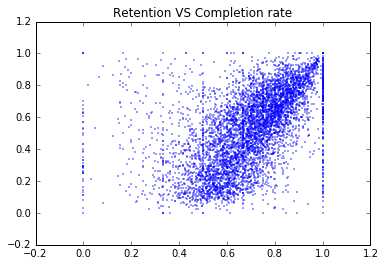

In [10]:
plt.scatter(data['RET_FT'], data['C150'], c='b', s=2, linewidths=0)
plt.title('Retention VS Completion rate')
plt.show()

In [101]:
faculty_cols = ['AVGFACSAL', 'PFTFAC', 'ADM_RATE_ALL']
stu_score_cols = ['ACTCMMID', 'SAT_AVG', 'SAT_AVG_ALL', 'SATVRMID', 'SATMTMID', 'SATWRMID']
cost_cols = ['COSTT4_A', 'COSTT4_P', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITIONFEE_PROG', 'TUITFTE', 
             'INEXPFTE', 'NPT4']
grant_loan_cols = ['PCTPELL', 'PCTFLOAN']
stu_composition_cols = ['NUM4', 'UG25abv', 'PFTFTUG1_EF', 'UGDS', 'PAR_ED_PCT_1STGEN', 
                        'PAR_ED_PCT_MS', 'PAR_ED_PCT_HS', 
                        'PAR_ED_PCT_PS', 'DEP_INC_AVG', 'IND_INC_AVG']
debt_cols = ['DEBT_MDN', 'GRAD_DEBT_MDN', 'WDRAW_DEBT_MDN']

# print (len(faculty_cols) + len(stu_score_cols) + len(cost_cols) + len(grant_loan_cols) +
#     len(stu_composition_cols) + len(debt_cols))
# set(col_desc.keys()) - set(faculty_cols + stu_score_cols + cost_cols + grant_loan_cols +
#     stu_composition_cols + debt_cols)

In [102]:
for col in col_desc.keys():
    if data.dtypes[col] == 'object':
        data[col] = data[col].replace(['PrivacySuppressed'], [float('NaN')]).astype(float)
#     print "-----"
#     print "{}:".format(col_desc[col])
#     print data[col].describe()


In [103]:
# For plotting purpose, split data based on:
#   4 year college and <4 year college
#   public, private and private for profit category

data_L4 = data[data['L4_COLLEGE']]
data_4  = data[~data['L4_COLLEGE']]

data_control1 = data[data.CONTROL == 1] # public
data_control2 = data[data.CONTROL == 2] # private non-profit
data_control3 = data[data.CONTROL == 3] # private profit


In [94]:
# print len(data_control1)
# print len(data_control1['NPT4_PUB'].dropna())
# print len(data_control1['NPT4_PRIV'].dropna())
# print '---'
# print len(data_control2)
# print len(data_control2['NPT4_PUB'].dropna())
# print len(data_control2['NPT4_PRIV'].dropna())
# print '---'
# print len(data_control3)
# print len(data_control3['NPT4_PUB'].dropna())
# print len(data_control3['NPT4_PRIV'].dropna())


Avg faculty salary VS completion


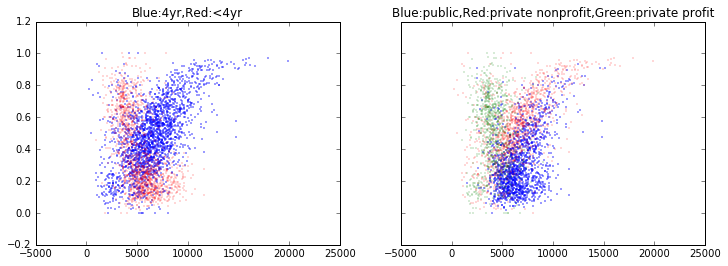

Full time faculty rate VS completion


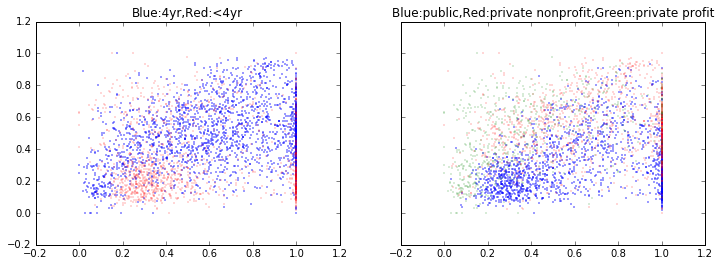

Admission rate VS completion


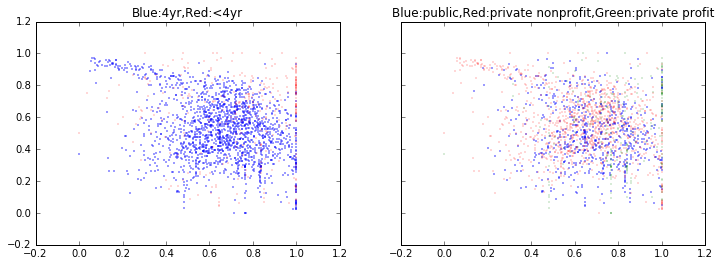

In [104]:
def plot_feature_vs_completion(cols, xscale=None):
    for col in cols:
        print "{} VS completion".format(col_desc[col])
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
        ax1.scatter(data_4[col], data_4['C150'], c='b', s=2, linewidths=0)
        ax1.scatter(data_L4[col], data_L4['C150'], c='r', s=2, linewidths=0, alpha=0.4)
        ax1.set_title("Blue:4yr,Red:<4yr")
        if xscale:
            ax1.set_xscale(xscale)
        
        ax2.scatter(data_control1[col], data_control1['C150'], c='b', s=2, linewidths=0)
        ax2.scatter(data_control2[col], data_control2['C150'], c='r', s=2, linewidths=0, alpha=0.4)
        ax2.scatter(data_control3[col], data_control3['C150'], c='g', s=2, linewidths=0, alpha=0.4)
        ax2.set_title("Blue:public,Red:private nonprofit,Green:private profit")
        if xscale:
            ax2.set_xscale(xscale)

        plt.show()

plot_feature_vs_completion(faculty_cols)

Carnegie classification-Size & settings VS completion


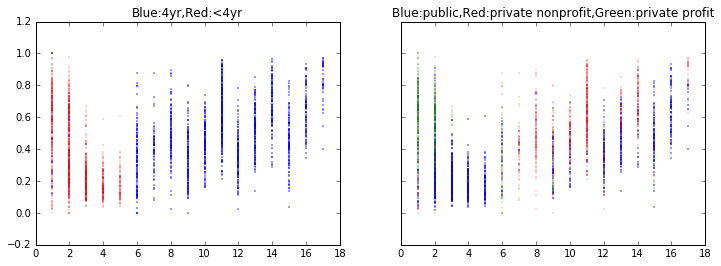

Carnegie classification-Undergrad profile  VS completion


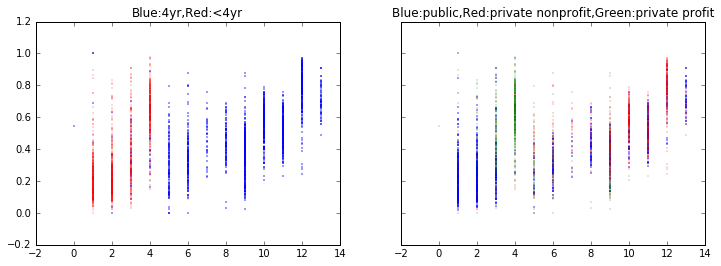

Carnegie classification-basic VS completion


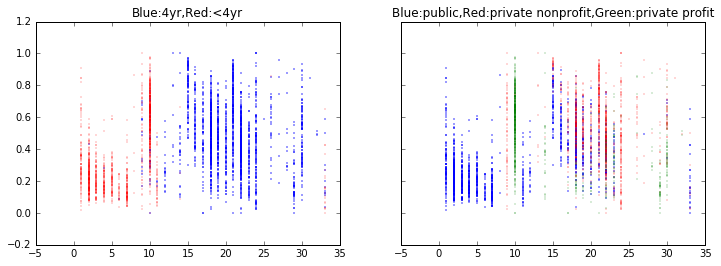

Degree of urbanization VS completion


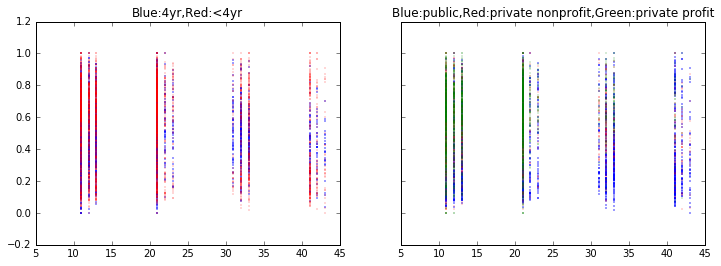

Region VS completion


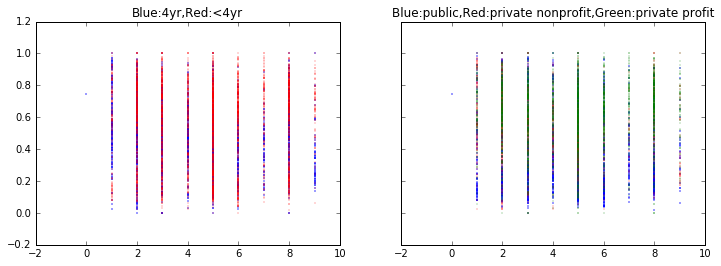

Predominant degree awarded VS completion


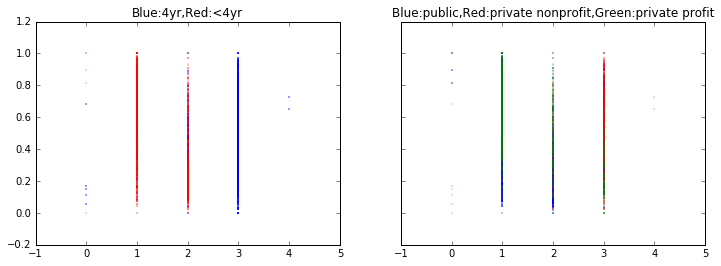

In [86]:
plot_feature_vs_completion(['CCSIZSET', 'CCUGPROF', 'CCBASIC', 'LOCALE', 'region', 'PREDDEG'])

ACT VS completion


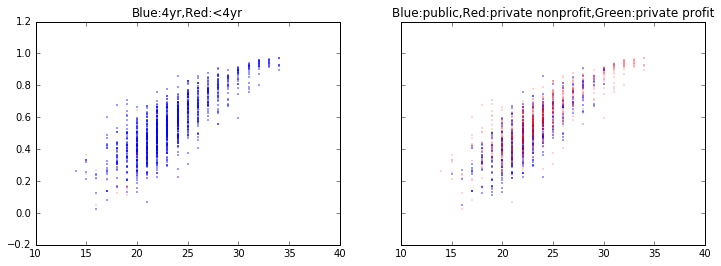

SAT VS completion


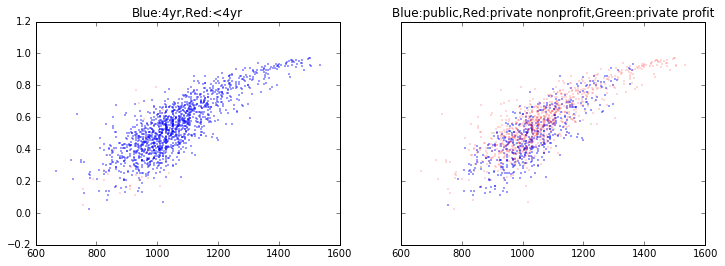

SAT all VS completion


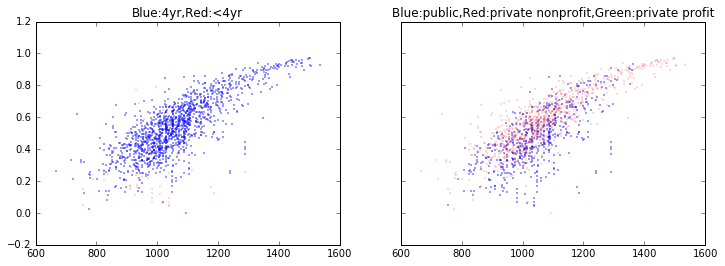

SAT reading VS completion


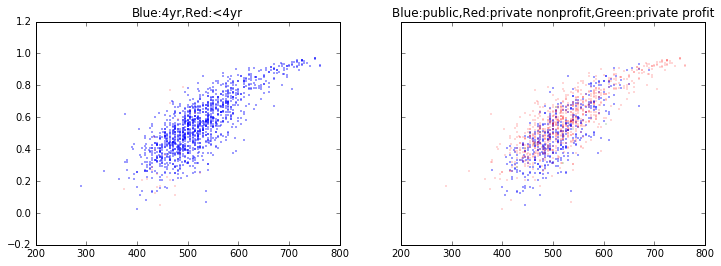

SAT math VS completion


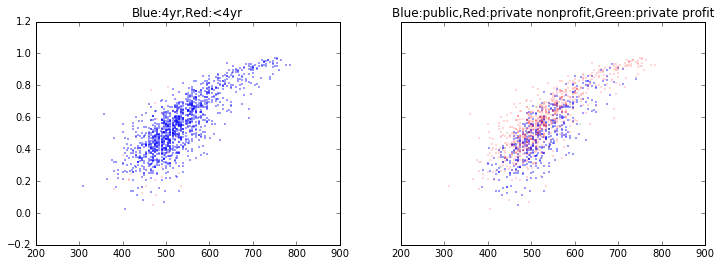

SAT writing VS completion


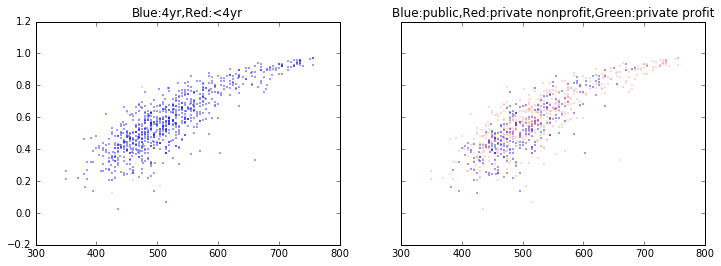

In [87]:
plot_feature_vs_completion(stu_score_cols)

Avg cost academic year VS completion


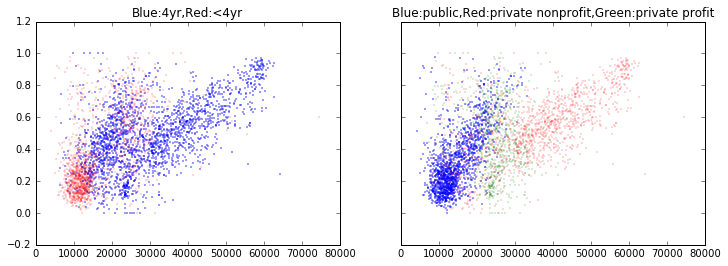

Avg cost program year VS completion


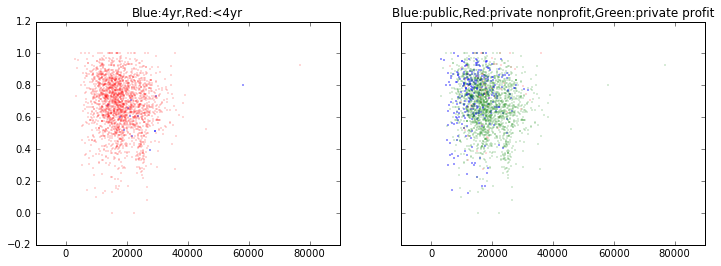

In state tuition VS completion


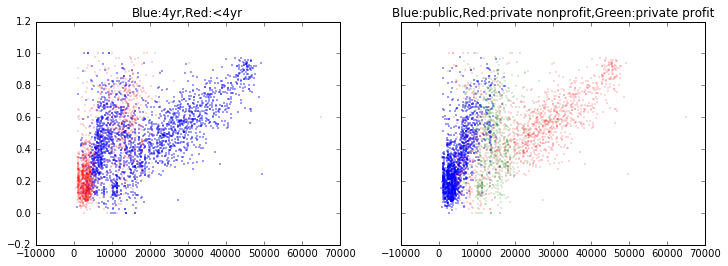

Out of state tuition VS completion


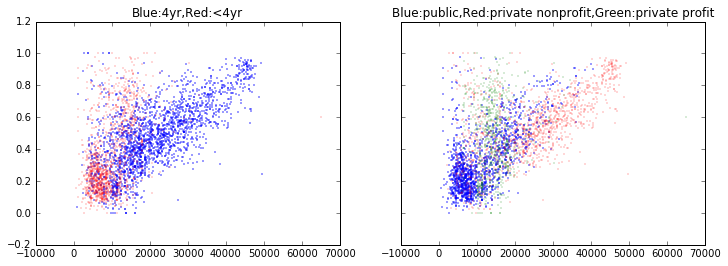

Tuition fee program year VS completion


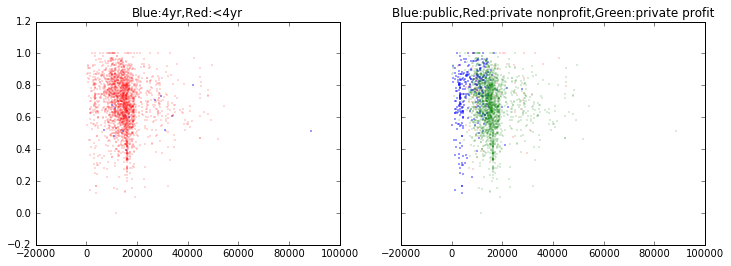

In [88]:
plot_feature_vs_completion(cost_cols[:5])

Net revenue per FTE student VS completion


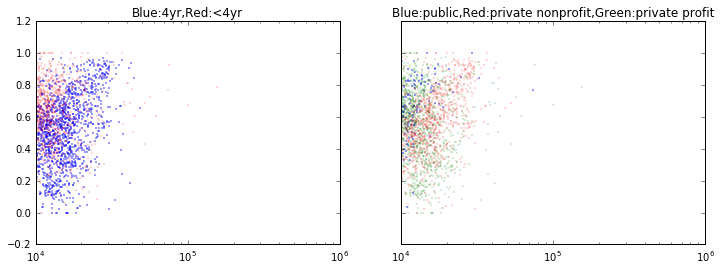

Expense per FTE student VS completion


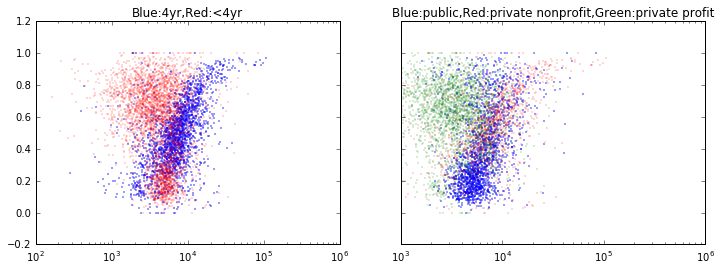

Avg net price Title IV VS completion


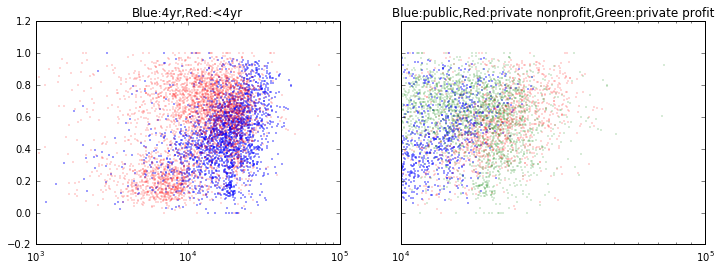

In [89]:
plot_feature_vs_completion(cost_cols[5:], xscale='log')

% Pell Grant receiver VS completion


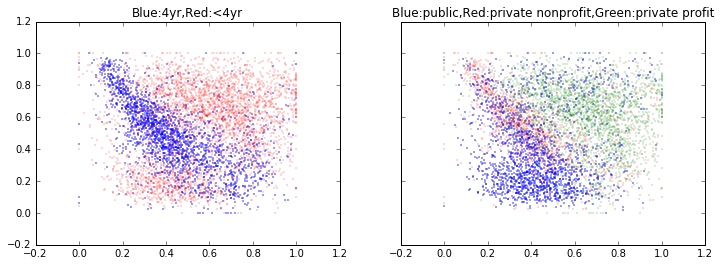

% Fed student loan VS completion


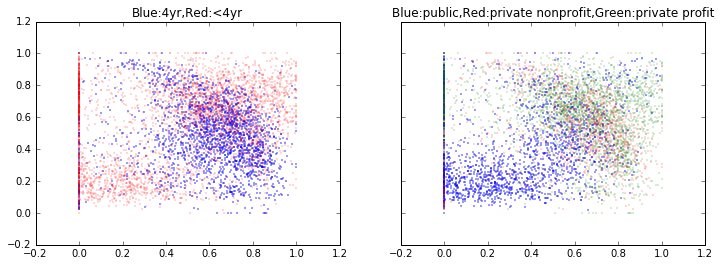

In [90]:
plot_feature_vs_completion(grant_loan_cols)

Num Title IV student VS completion


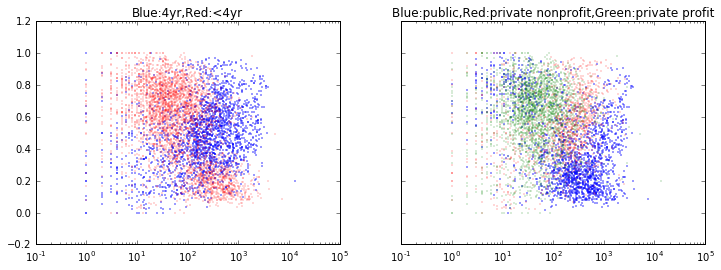

% undergrad > 25 yr VS completion


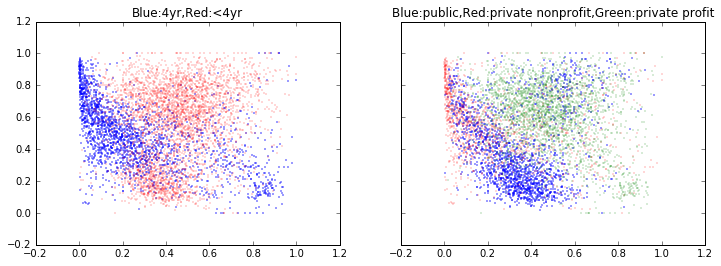

Undergrad 1st-time degree seeking VS completion


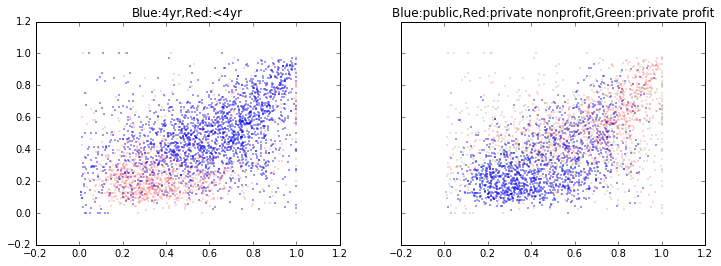

Number of Undergrad degree seeking VS completion


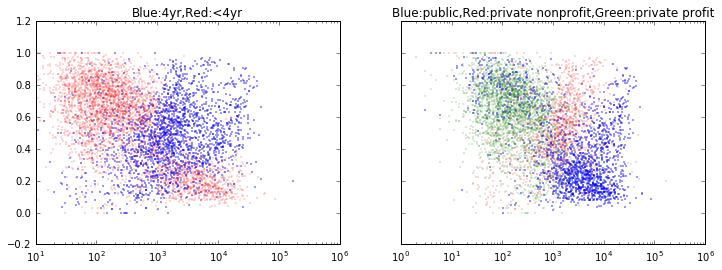

In [107]:
# print stu_composition_cols
plot_feature_vs_completion(['NUM4'], xscale='log')
plot_feature_vs_completion(['UG25abv', 'PFTFTUG1_EF'])
plot_feature_vs_completion(['UGDS'], xscale='log')

% 1st gen students VS completion


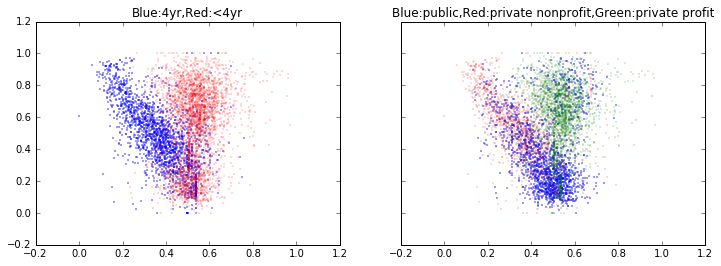

% parent education middle school VS completion


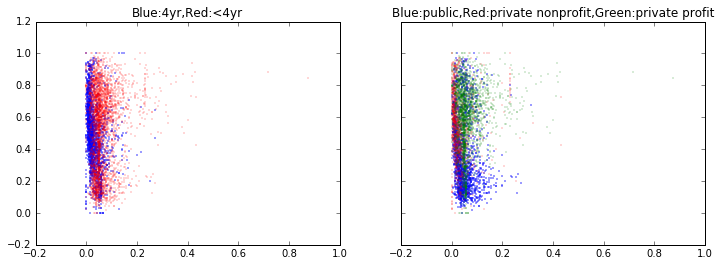

% parent education high school VS completion


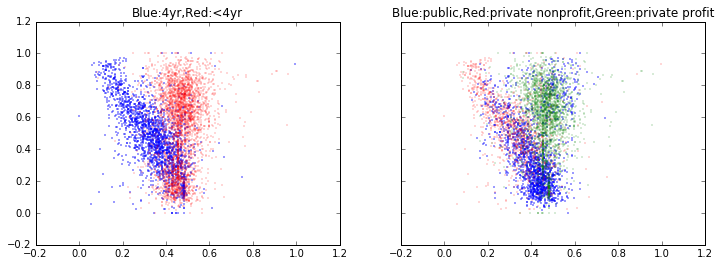

% parent education post secondary VS completion


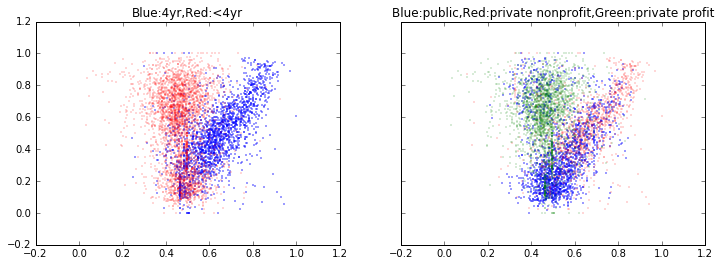

Avg income dependent stu VS completion


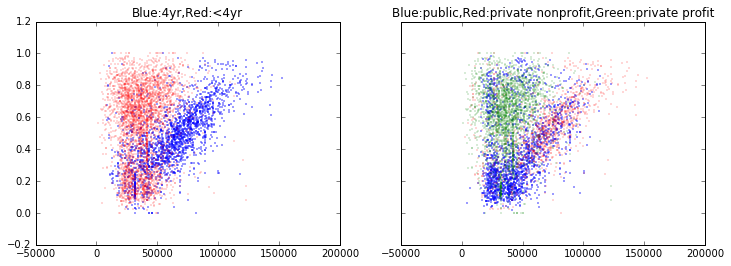

In [30]:
# print stu_composition_cols
plot_feature_vs_completion(stu_composition_cols[5:10])

Median debt VS completion


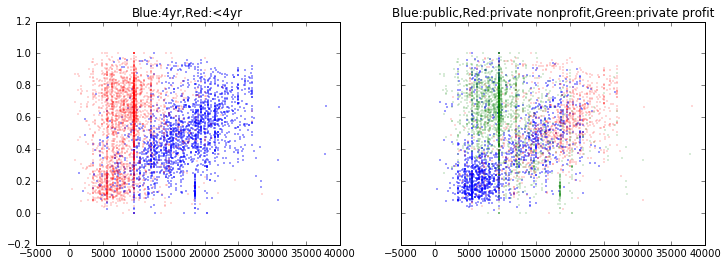

Median debt complete VS completion


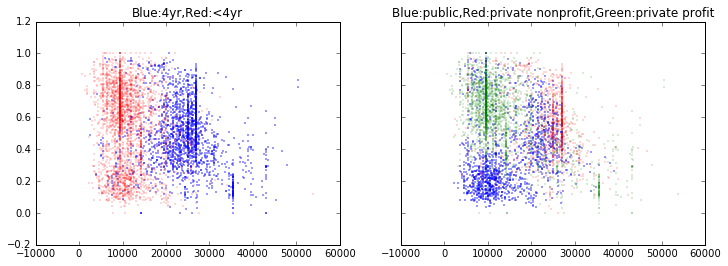

Median debt non-completer VS completion


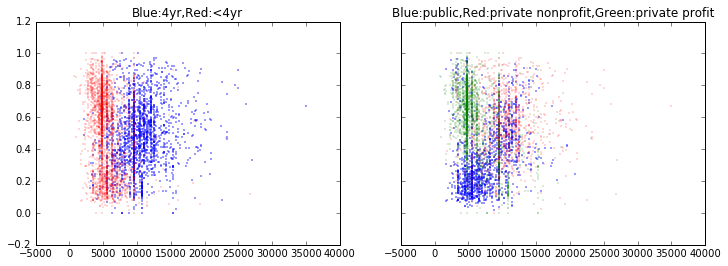

In [93]:
plot_feature_vs_completion(debt_cols)

In [452]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['SAT_AVG', 'ACTCMMID']], data['C150'], test_size=0.2)
print [len(X_train), len(X_test)]
X_train.head()

[5130, 1283]


,SAT_AVG,ACTCMMID
6007,NaN,NaN
628,NaN,NaN
4333,NaN,NaN
4510,NaN,NaN
3470,NaN,NaN
